<a href="https://colab.research.google.com/github/Selamawit-Alemu/fraud_detection_project/blob/task-3/notebooks/3_model_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls -l /content/drive/MyDrive/models/

total 3406
-rw------- 1 root root  893832 Jul 26 05:34 logistic_regression_pipeline.pkl
-rw------- 1 root root 1789886 Jul 26 05:34 preprocessor.pkl
-rw------- 1 root root    1767 Jul 26 05:31 scaler_credit.pkl
-rw------- 1 root root  534798 Jul 26 05:31 xgboost_credit_model_xgb.json
-rw------- 1 root root  266419 Jul 26 05:34 xgboost_model.json


In [3]:
# --- Step 1: Load Data and Model for SHAP ---

import pandas as pd
import joblib
import shap
import xgboost as xgb

# Paths
model_dir = "/content/drive/MyDrive/models"
data_path = "/content/drive/MyDrive/data/processed_fraud_data.csv"  # adjust if needed

# Load preprocessed fraud data
df = pd.read_csv(data_path)
#print(df.columns)

# Drop label if it's in the dataset (we'll keep it separately)
X = df.drop("class", axis=1)
y = df["class"]


# Load the XGBoost model
xgb_model = xgb.Booster()
xgb_model.load_model(f"{model_dir}/xgboost_model.json")

print("✅ Data and model loaded successfully.")


✅ Data and model loaded successfully.


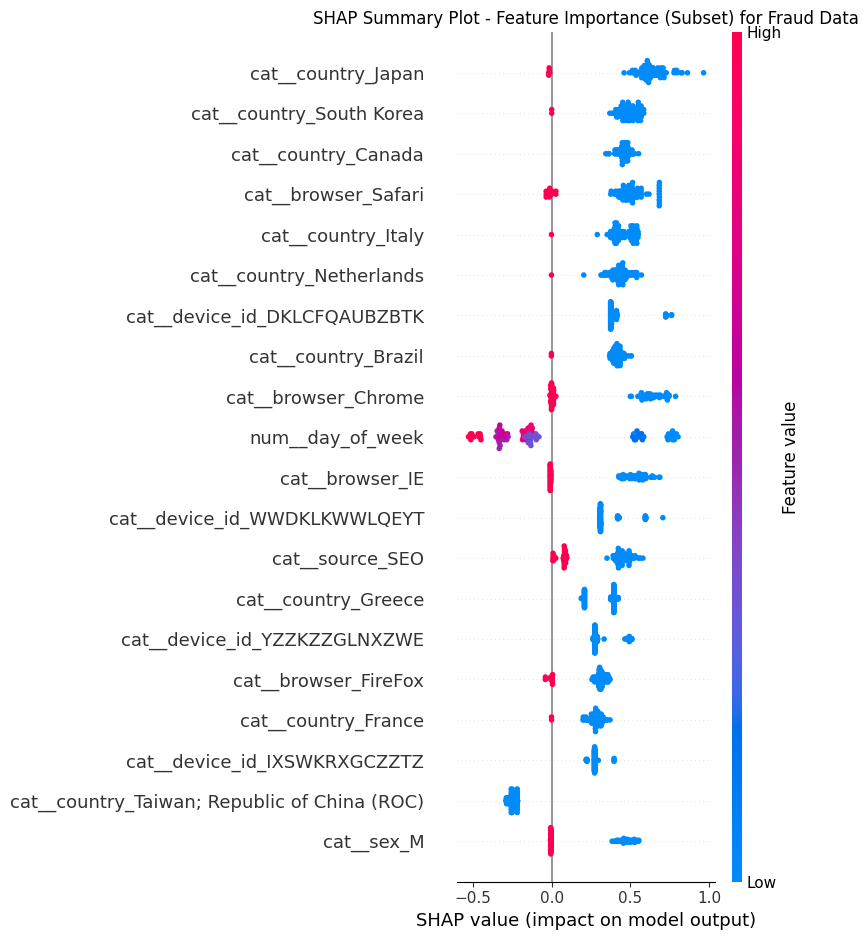


SHAP Force Plot for first sample in subset-Fraud Data:


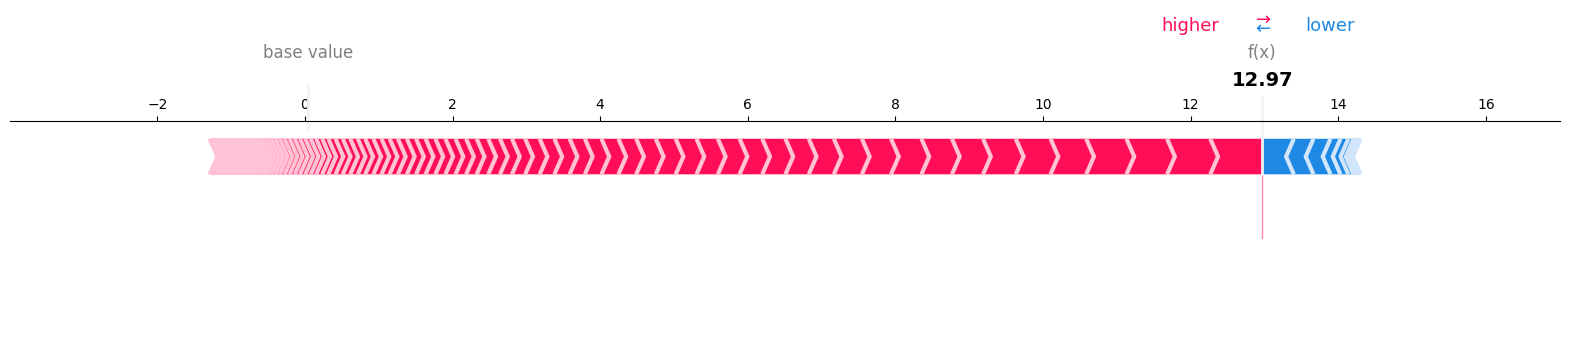

In [5]:
import shap
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb
import pandas as pd

# Load saved objects
model_dir = '/content/drive/MyDrive/models'
preprocessor = joblib.load(f"{model_dir}/preprocessor.pkl")

xgb_model = xgb.Booster()
xgb_model.load_model(f"{model_dir}/xgboost_model.json")

# Load data and split
data_path = '/content/drive/MyDrive/data/processed_fraud_data.csv'
df = pd.read_csv(data_path)

target = 'class'
X = df.drop(columns=[target, 'user_id', 'signup_time', 'purchase_time'])
y = df[target]

from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocess test data
X_test_processed = preprocessor.transform(X_test)

# Feature names
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrame
if hasattr(X_test_processed, "toarray"):
    X_test_df = pd.DataFrame(X_test_processed.toarray(), columns=feature_names)
else:
    X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

# *** Select a smaller random subset for SHAP ***
subset_size = 100  # tune this number (100 is usually safe in Colab)
X_shap_sample = X_test_df.sample(n=subset_size, random_state=42)

# Create DMatrix for XGBoost explainer input
dmat_shap = xgb.DMatrix(X_shap_sample)

# SHAP explainer and values for subset only
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap_sample)

# SHAP summary plot for subset
plt.title("SHAP Summary Plot - Feature Importance (Subset) for Fraud Data")
shap.summary_plot(shap_values, X_shap_sample, show=True)

# SHAP force plot for first sample in subset (local explanation)
print("\nSHAP Force Plot for first sample in subset-Fraud Data:")
shap.force_plot(explainer.expected_value, shap_values[0,:], X_shap_sample.iloc[0,:], matplotlib=True)


SHAP Summary Plot Interpretation

    Purpose: Shows which features globally influence the model predictions the most.

    Key observations:

        Features like country (Japan, South Korea, Canada) and browser type (Safari) tend to increase the fraud prediction score.

        Features such as Chrome browser usage, higher day of the week (closer to weekend), and male gender tend to decrease the fraud prediction score.

        The color-coded dots reveal how feature values correlate with their impact:

            Red dots = high feature values

            Blue dots = low feature values

        For example, a high presence of cat_country_Japan (red) pushes prediction higher, meaning users from Japan are more associated with fraud likelihood according to the model.

SHAP Force Plot Interpretation (Local Explanation)

    Purpose: Explains why the model predicted a specific fraud risk score for an individual transaction.

    Key insights:

        The base value is the average model prediction without feature info.

        Red arrows represent features pushing the prediction higher (more likely fraud).

        Blue arrows represent features pushing the prediction lower (less likely fraud).

        In your plot, most features pushed the prediction significantly higher, resulting in a high fraud risk score (~12.97).

        A few features pushed it down slightly but not enough to offset the strong positive contributors.

What These Plots Reveal About Fraud Drivers:

    Global drivers: Geographic location (country) and browser type are strong indicators. Certain countries and browsers increase fraud risk, while others decrease it.

    Temporal patterns: Days of the week also influence fraud likelihood, with weekends showing lower fraud risk in this dataset.

    User attributes: Gender and device-related features also contribute but in a more nuanced way.

    Local prediction: The force plot shows the exact combination of feature values that led to the fraud score for an individual transaction, highlighting which features were most influential locally.

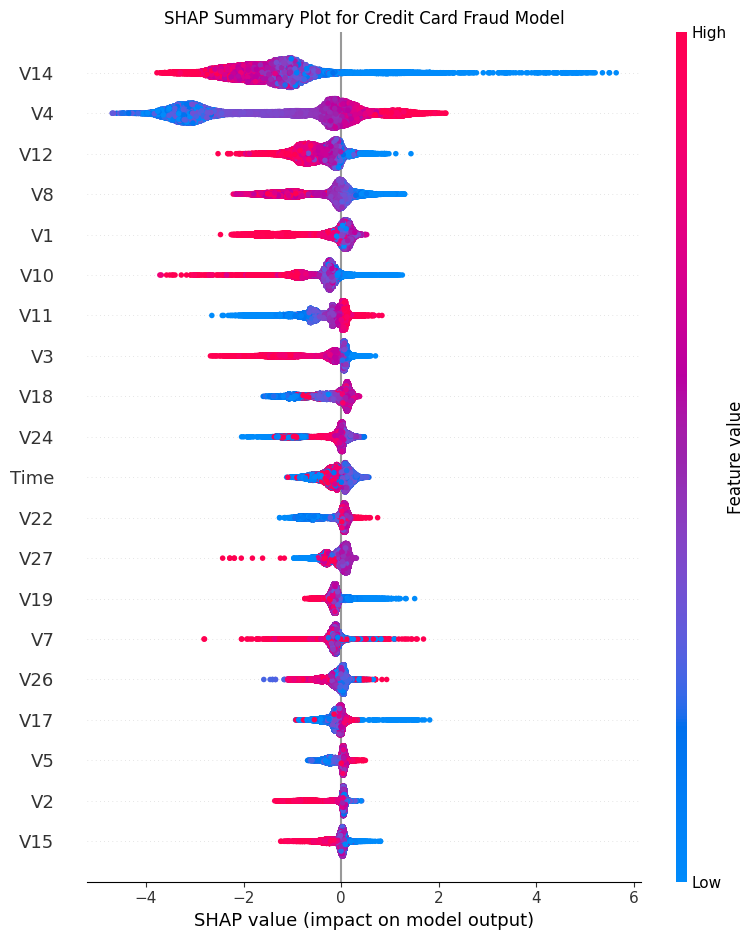

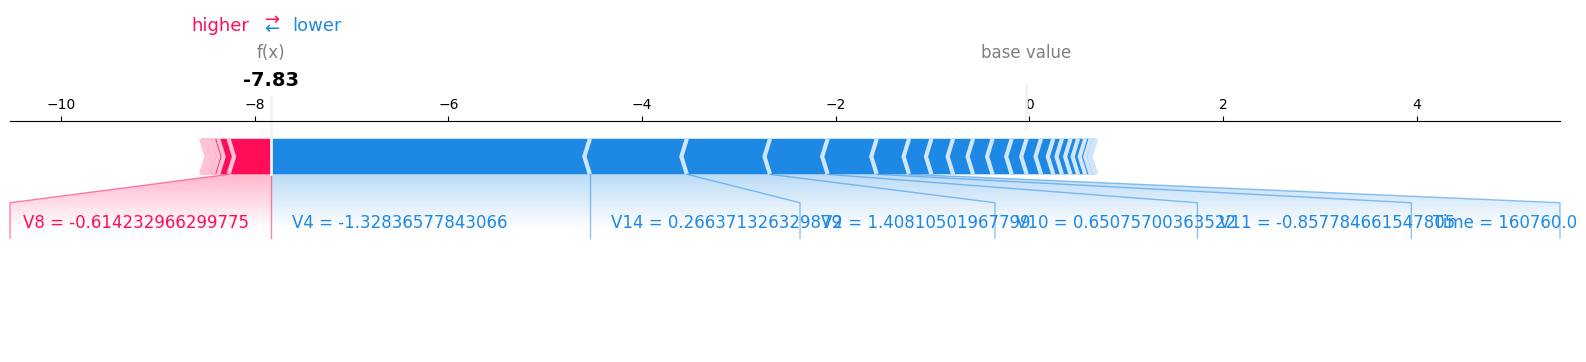

In [6]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb

# 1. Load saved model and scaler (adjust paths accordingly)
model_path = '/content/drive/MyDrive/models/xgboost_credit_model_xgb.json'
scaler_path = '/content/drive/MyDrive/models/scaler_credit.pkl'

xgb_model = xgb.Booster()
xgb_model.load_model(model_path)
scaler = joblib.load(scaler_path)

# 2. Load your test data (adjust path accordingly)
# Assume df_credit is your full dataset with 'Class' as target
df_credit = pd.read_csv('/content/drive/MyDrive/data/creditcard.csv')
target = 'Class'
X = df_credit.drop(columns=[target])
y = df_credit[target]

# 3. Split test data or load your test set (here using 20% split for example)
from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4. Scale test features using saved scaler
X_test_scaled = scaler.transform(X_test)

# 5. Convert test data to DMatrix for XGBoost
dtest = xgb.DMatrix(X_test_scaled)

# 6. Use SHAP TreeExplainer for XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# 7. Calculate SHAP values for test set
shap_values = explainer.shap_values(dtest)

# 8. Plot SHAP summary plot (global feature importance)
plt.title("SHAP Summary Plot for Credit Card Fraud Model")
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=True)

# 9. Select one sample from test set for force plot (local explanation)
sample_index = 0  # Change as needed
sample = X_test_scaled[sample_index:sample_index+1]
sample_original = X_test.iloc[sample_index:sample_index+1]

# Calculate SHAP values for the sample
shap_values_sample = explainer.shap_values(xgb.DMatrix(sample))

# 10. Generate SHAP force plot for single prediction
shap.initjs()
force_plot = shap.force_plot(explainer.expected_value, shap_values_sample, sample_original, matplotlib=True)
plt.show()


 SHAP Interpretation – Credit Card Fraud Detection

To understand how our best-performing model (XGBoost) makes its decisions, we used SHAP (SHapley Additive exPlanations) to analyze both global and local feature contributions.
 1. Global Explanation – SHAP Summary Plot

The SHAP summary plot provides a comprehensive view of which features most significantly influence the model’s predictions across the entire dataset. In our analysis:

    Top influential features included:

        V14: High values increase fraud risk.

        V4: High values are associated with higher fraud probability.

        V12: Lower values tend to signal fraud.

    SHAP values capture both magnitude and direction of feature impact.

        For example, high SHAP values (pink) for V14 push the prediction toward fraud (positive class).

        In contrast, low V12 values contribute strongly toward fraud predictions.

This plot confirms that the model relies heavily on a few key features—despite the data being anonymized—demonstrating its ability to distinguish fraud patterns from legitimate behavior.

 2. Local Explanation – SHAP Force Plot

To dive deeper into a specific prediction, we used a SHAP force plot to explain an individual case from the test set.

    For this example, the model predicted "Not Fraud" with a strong margin (f(x) = –7.83).

    Key features influencing this decision:

        V4 = -1.328, V14 = 0.266, and V10 = 0.650

    These features had negative SHAP values, pulling the model's output away from predicting fraud.

    The force plot shows how each feature adds or subtracts risk from the model’s output score, with blue bars reducing the fraud score and red bars increasing it.

This localized explanation improves model transparency and can help in real-world fraud case investigations or alert validations.

 Conclusion

SHAP enhances our model’s explainability by showing why a prediction was made—not just what was predicted. This is crucial for:

    Building trust with stakeholders.

    Complying with regulatory transparency.

    Supporting model debugging and continuous improvement.

By combining global and local SHAP analysis, we gain a clearer understanding of the model’s behavior, improving confidence in its deployment for real-time fraud detection.